In [83]:
import torch
import torch.optim as optim
import numpy as np
from torchdiffeq import odeint
from astropy import units as u
from astropy import constants as const
from astropy.coordinates import EarthLocation, SkyCoord, AltAz, ITRS, GCRS
from astropy.time import Time
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
from tqdm import trange
from utils.orbital_utils import SatelliteODEThrust, SatelliteODEPhysicsOnly, MLP, PINN, physics_model, thrust_model

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

R_REF = 42164140.0
V_REF = 3074.6
scaling = torch.tensor([R_REF, R_REF, R_REF, V_REF, V_REF, V_REF], dtype=torch.float64)

print(f"Scaled initial state guess (km and km/s): {scaling.cpu().numpy()}")

Scaled initial state guess (km and km/s): [4.216414e+07 4.216414e+07 4.216414e+07 3.074600e+03 3.074600e+03
 3.074600e+03]


In [19]:
#### Auxiliary Functions for RA/Dec Calculation and Plotting

def calculate_ra_dec_eci(trajectory):
    """
    Differentiable ECI RA/Dec calculation.
    Input trajectory: Tensor of shape (30, 6)
    """
    # 1. Extract position components
    x = trajectory[:, 0]
    y = trajectory[:, 1]
    z = trajectory[:, 2]
    
    # 2. Calculate magnitude using torch.norm (dim=1 for the 30 rows)
    r_mag = torch.norm(trajectory[:, :3], dim=1)
    
    # 3. Calculate Right Ascension (RA)
    # Use torch.atan2 and convert to degrees
    ra = torch.atan2(y, x) * (180.0 / torch.pi)
    
    # Use torch.remainder for the 0-360 wrap-around
    # This is differentiable, whereas 'if/else' logic or numpy modulo is not
    ra = torch.remainder(ra, 360.0)
    
    # 4. Calculate Declination (Dec)
    # Use torch.asin and convert to degrees
    dec = torch.asin(z / r_mag) * (180.0 / torch.pi)

    return ra, dec

def plot_ra_dec_eci(t, trajectory):
    # Convert time to hours
    if hasattr(t, 'detach'):
        t_plot = t.detach().cpu().numpy() / 3600.0
    else:
        t_plot = np.array(t) / 3600.0

    ra, dec = calculate_ra_dec_eci(trajectory)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    fig.suptitle('Geocentric ECI Observations', fontsize=14)

    # RA Plot
    ax.scatter(t_plot, ra, color='royalblue', s=1, label='Right Ascension')
    # Dec Plot
    ax.scatter(t_plot, dec, color='red', s=1, label='Declination')

    ax.set_ylabel('Degrees')
    ax.set_xlabel('Time (hours)')
    ax.set_ylim(-100, 100)
    ax.grid(True, alpha=0.3)
    ax.legend()

    plt.tight_layout()
    plt.show()

def circular_mse_loss(pred_deg, target_deg):
    """
    Calculates MSE while accounting for the 0/360 degree wrap-around.
    
    This loss function is designed for circular quantities like Right Ascension (RA)
    and Declination (Dec), where 0° and 360° represent the same angle. It computes
    the mean squared error using the shortest angular distance between predictions
    and targets.
    
    Args:
        pred_deg (torch.Tensor): Predicted angles in degrees
        target_deg (torch.Tensor): Target angles in degrees
    
    Returns:
        torch.Tensor: Mean squared error accounting for circular wrap-around, in degrees²
    
    Example:
        >>> pred = torch.tensor([359.0, 1.0])
        >>> target = torch.tensor([1.0, 359.0])
        >>> loss = circular_mse_loss(pred, target)
        # Returns ~4.0 (distance of 2° for each), not ~(358²)
    """
    # Convert degrees to radians
    pred_rad = pred_deg * (torch.pi / 180.0)
    target_rad = target_deg * (torch.pi / 180.0)
    
    # Method 1: Difference based
    # Calculate shortest angular distance using atan2
    diff = torch.atan2(torch.sin(pred_rad - target_rad), torch.cos(pred_rad - target_rad))
    
    # Return MSE of the shortest distance (in degrees)
    return torch.mean((diff * (180.0 / torch.pi))**2)

def get_better_x0(ra1, dec1, ra2, dec2, delta_t):
    """
    Estimate initial state vector from two RA/Dec observations.
    
    Assumes the satellite is at GEO radius and uses two observations
    separated by delta_t to estimate position and velocity.
    
    Args:
        ra1 (float): Right Ascension of first observation (degrees)
        dec1 (float): Declination of first observation (degrees)
        ra2 (float): Right Ascension of second observation (degrees)
        dec2 (float): Declination of second observation (degrees)
        delta_t (float): Time between observations (seconds)
    
    Returns:
        torch.Tensor: Initial state [rx, ry, rz, vx, vy, vz] in meters and m/s
    """
    r_geo = 42164140.0  # GEO radius in meters
    
    # Convert degrees to radians
    phi1, theta1 = torch.deg2rad(dec1), torch.deg2rad(ra1)
    phi2, theta2 = torch.deg2rad(dec2), torch.deg2rad(ra2)
    
    # Unit vectors for observations 1 and 2 (ECI frame)
    L1 = torch.tensor([torch.cos(phi1)*torch.cos(theta1), 
                       torch.cos(phi1)*torch.sin(theta1), 
                       torch.sin(phi1)], dtype=torch.float64)
    
    L2 = torch.tensor([torch.cos(phi2)*torch.cos(theta2), 
                       torch.cos(phi2)*torch.sin(theta2), 
                       torch.sin(phi2)], dtype=torch.float64)
    
    # Position estimates at GEO radius
    pos0 = L1 * r_geo
    pos1 = L2 * r_geo
    
    # Velocity estimate: finite difference approximation
    vel0 = (pos1 - pos0) / delta_t
    
    return torch.cat([pos0, vel0])

def calculate_position_error(trajectory, reference_trajectory):
    """
    Calculate position error between predicted and reference trajectories.
    
    Computes the Euclidean distance between position vectors (first 3 components)
    of the predicted trajectory and reference trajectory at each time step.
    
    Args:
        trajectory (torch.Tensor): Predicted trajectory of shape (N, 6) where
            columns 0-2 are position components [x, y, z] in meters
        reference_trajectory (torch.Tensor): Reference trajectory of shape (N, 6)
            with same structure as trajectory
    
    Returns:
        torch.Tensor: Position errors of shape (N,) in kilometers, representing
            the magnitude of position difference at each time step
    
    Example:
        >>> pred = torch.tensor([[1e7, 2e7, 3e7, 100, 200, 300]])
        >>> ref = torch.tensor([[1.1e7, 2.1e7, 3.1e7, 110, 210, 310]])
        >>> error = calculate_position_error(pred, ref)
        # Returns tensor with euclidean distance in km
    """
    return torch.norm(trajectory[:, :3] - reference_trajectory[:, :3], dim=1) / 1000.0


def calculate_velocity_error(trajectory, reference_trajectory):
    """
    Calculate velocity error between predicted and reference trajectories.
    
    Computes the Euclidean distance between velocity vectors (last 3 components)
    of the predicted trajectory and reference trajectory at each time step.
    
    Args:
        trajectory (torch.Tensor): Predicted trajectory of shape (N, 6) where
            columns 3-5 are velocity components [vx, vy, vz] in m/s
        reference_trajectory (torch.Tensor): Reference trajectory of shape (N, 6)
            with same structure as trajectory
    
    Returns:
        torch.Tensor: Velocity errors of shape (N,) in m/s, representing
            the magnitude of velocity difference at each time step
    
    Example:
        >>> pred = torch.tensor([[1e7, 2e7, 3e7, 100, 200, 300]])
        >>> ref = torch.tensor([[1.1e7, 2.1e7, 3.1e7, 110, 210, 310]])
        >>> error = calculate_velocity_error(pred, ref)
        # Returns tensor with euclidean distance in m/s
    """
    return torch.norm(trajectory[:, 3:] - reference_trajectory[:, 3:], dim=1)

In [20]:
# Initialize seed for reproducibility
torch.manual_seed(42)

# set seed for numpy as well to ensure all random operations are consistent
np.random.seed(42)

Define an arbitrary thrust profile:

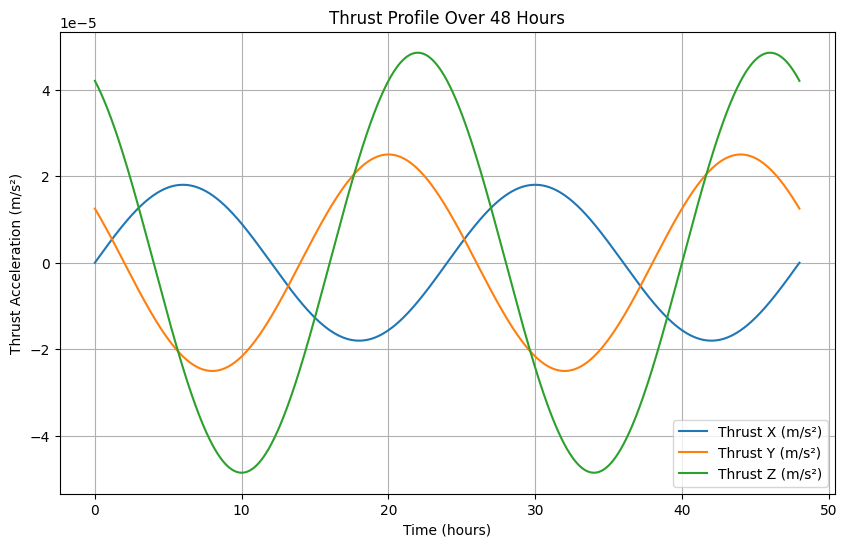

In [21]:
# plot the thrust profile over 48 hours
time_array = torch.arange(0, 3600*48 + 10, 10, dtype=torch.float64)
thrust_profile = torch.stack([thrust_model(t) for t in time_array])


plt.figure(figsize=(10, 6))
plt.plot(time_array.numpy()/3600, thrust_profile[:,0].numpy(), label='Thrust X (m/s²)')
plt.plot(time_array.numpy()/3600, thrust_profile[:,1].numpy(), label='Thrust Y (m/s²)')
plt.plot(time_array.numpy()/3600, thrust_profile[:,2].numpy(), label='Thrust Z (m/s²)')
plt.xlabel('Time (hours)')
plt.ylabel('Thrust Acceleration (m/s²)')
plt.title('Thrust Profile Over 48 Hours')
plt.legend()
plt.grid()
plt.show()  

Ensure the Delta-V is reasonable and approx. 10 m/s:

In [22]:
# Integrate all 3 components of thrust over 48 hours to get delta-V
delta_v = torch.zeros(3, dtype=torch.float64)
for t in time_array:
    delta_v += abs(thrust_model(t)) * 10  # 10 seconds step  
print(f"Total Delta-V over 48 hours: {delta_v.numpy()} m/s")

# sum of absolute values of delta-v components
total_delta_v = torch.sum(delta_v).item()

print(f"Sum of absolute Delta-V components: {total_delta_v:.4f} m/s")


Total Delta-V over 48 hours: [1.98014205 2.7503223  5.33580278] m/s
Sum of absolute Delta-V components: 10.0663 m/s


Define and propagate the initial orbital state for 48 hours:

Inclined GEO Initial State (i=5°, e=0):
tensor([4.2164e+07, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0736e+03, 8.0485e+01],
       dtype=torch.float64)
Inclination: 1.5°
Eccentricity: 0.0 (Circular)
Inclined GEO Initial State Vector:
tensor([4.2164e+07, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0736e+03, 8.0485e+01],
       dtype=torch.float64)


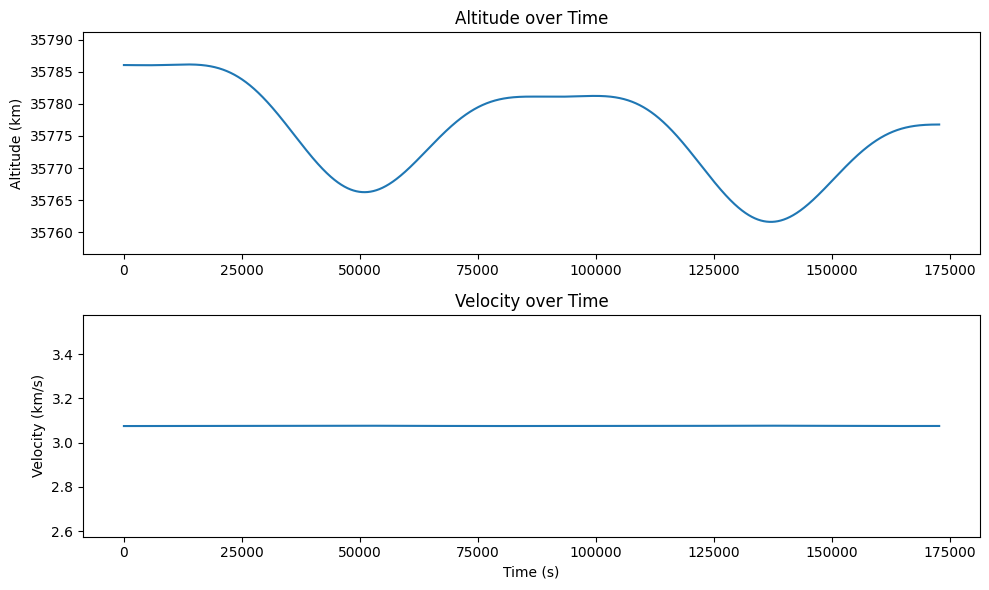

In [23]:
# 1. GEO Parameters
r_geo_mag = 42164140.0 # meters (Semi-major axis for circular GEO)
mu = const.GM_earth.value

# 2. Calculate Circular Velocity Magnitude
# v = sqrt(mu / r)
v_circ_mag = np.sqrt(mu / r_geo_mag)

# 3. Define Orbital Elements
inclination_deg = 1.5
i_rad = np.radians(inclination_deg)

# 4. Construct the State Vector
# Position: Place the satellite on the X-axis (Line of Nodes)
r_0 = torch.tensor([r_geo_mag, 0.0, 0.0], dtype=torch.float64)

# Velocity: Rotate the velocity vector around the X-axis by the inclination
# For a satellite at the node (on X), the velocity in an equatorial orbit is purely on Y.
# Tilted velocity: Vy = v*cos(i), Vz = v*sin(i)
v_0 = torch.tensor([
    0.0, 
    v_circ_mag * np.cos(i_rad), 
    v_circ_mag * np.sin(i_rad)
], dtype=torch.float64)

# Combined State Vector X = [r, v]
x0_inclined = torch.cat([r_0, v_0])

print(f"Inclined GEO Initial State (i=5°, e=0):\n{x0_inclined}")
print(f"Inclination: {inclination_deg}°")
print(f"Eccentricity: 0.0 (Circular)")

print(f"Inclined GEO Initial State Vector:\n{x0_inclined}")
#print(f"Initial Altitude: {(r_geo_mag - const.R_earth).to(u.km):.2f}")

# 2. Propagation Execution
#t = torch.linspace(0, 3600*48,1000) # Propagate for 2 days
# define the t-tensor so that the integration step is 10 seconds
t = torch.arange(0, 3600*48 + 10, 10, dtype=torch.float64)

model = SatelliteODEThrust()
# Use 'dopri5' or 'rk4' for integration
with torch.no_grad():
    trajectory = odeint(model, x0_inclined, t, method='rk4')
# Compute altitude and velocity
r_mag = torch.norm(trajectory[:, :3], dim=1)
altitude = r_mag - const.R_earth.to(u.m).value
velocity = torch.norm(trajectory[:, 3:], dim=1)

# Plot altitude and velocity

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

ax1.plot(t.numpy(), altitude.numpy()/1000)
ax1.set_title('Altitude over Time')
ax1.set_ylabel('Altitude (km)')
ax1.set_ylim(altitude.numpy().min()/1000-5, altitude.numpy().max()/1000+5)

ax2.plot(t.numpy(), velocity.numpy()/1000)
ax2.set_title('Velocity over Time')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Velocity (km/s)')
ax2.set_ylim(velocity.numpy().min()/1000-0.5, velocity.numpy().max()/1000+0.5)
plt.tight_layout()
plt.show()



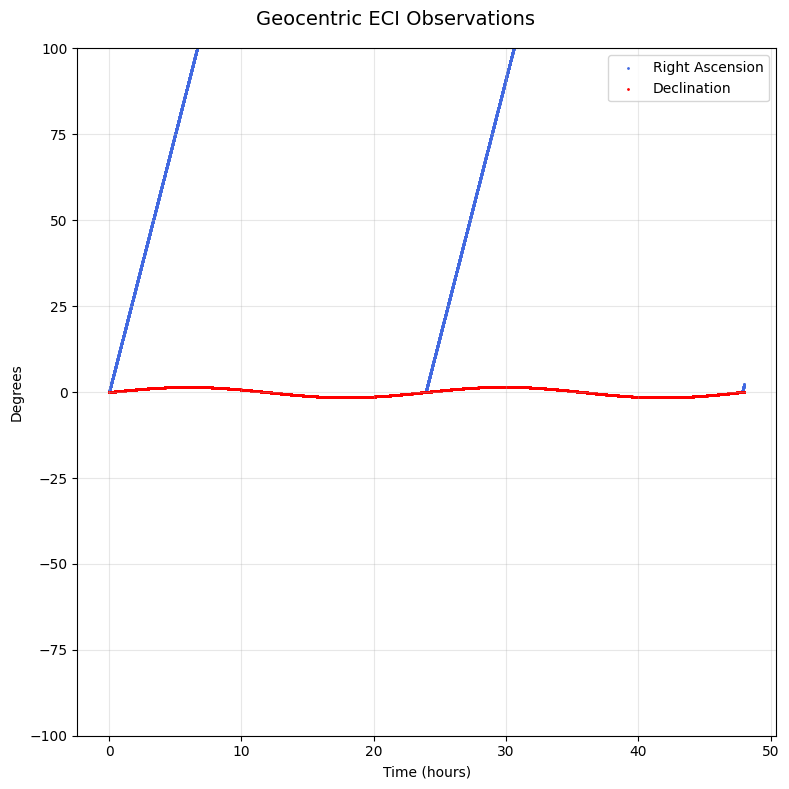

In [24]:
plot_ra_dec_eci(t, trajectory)

<br>

Simulate the right ascension and declination observations and add noise:

In [25]:
# Get 50 random observation times within the propagation period
num_observations = 250

# Ensure the first observation (index 0) is always included
# Choose 49 random indices from 1 to len(t)-1
additional_indices = np.random.choice(np.arange(1, len(t)), size=num_observations-1, replace=False)
observation_indices = np.sort(np.concatenate([[0], additional_indices]))
observation_times = t[observation_indices]

In [26]:
# Get RA and Dec at observation times
ra_obs, dec_obs = calculate_ra_dec_eci(trajectory[observation_indices])

# Add noise to observations, from a normal distribution with mean 0 and stddev 0.5 arcseconds
noise_stddev_arcsec = 0.5
noise_stddev_deg = noise_stddev_arcsec / 3600.0  # Convert to degrees

ra_noise = np.random.normal(0, noise_stddev_deg, size=len(ra_obs))

ra_obs_noisy = ra_obs + ra_noise

dec_noise = np.random.normal(0, noise_stddev_deg, size=len(dec_obs))

dec_obs_noisy = dec_obs + dec_noise

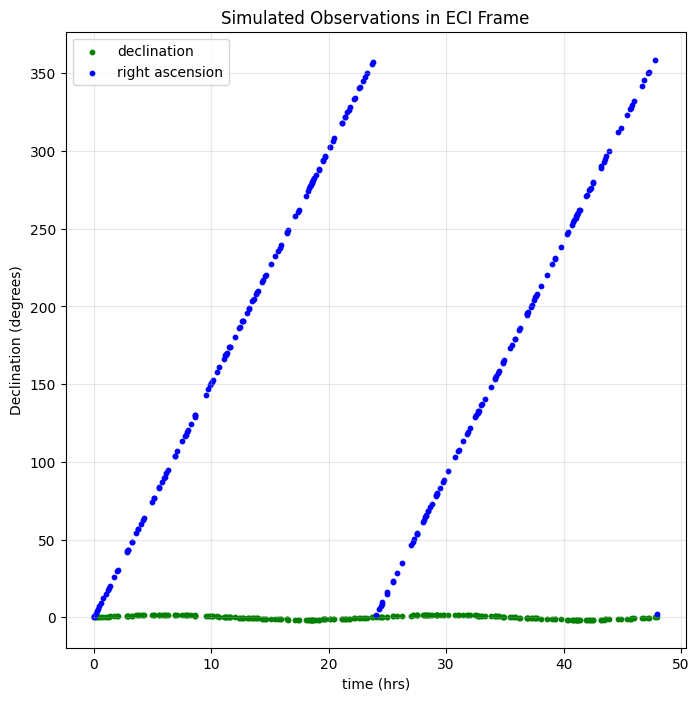

In [27]:
fig, ax = plt.subplots(figsize=(8, 8))
# Plot RA and DEC observations
ax.scatter(observation_times/3600.0, dec_obs_noisy, color='green', s=10, label='declination')
ax.scatter(observation_times/3600.0, ra_obs_noisy, color='blue', s=10, label='right ascension')
ax.set_xlabel('time (hrs)')  
ax.set_ylabel('Declination (degrees)')
ax.set_title('Simulated Observations in ECI Frame')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()



In [28]:
ra_obs_noisy_tensor = torch.tensor(ra_obs_noisy, dtype=torch.float64)
dec_obs_noisy_tensor = torch.tensor(dec_obs_noisy, dtype=torch.float64)

Solve using physics-only model, and guess an initial state from the first two observations

In [29]:
# Use your first two data points
x0_improved = get_better_x0(ra_obs_noisy_tensor[0], dec_obs_noisy_tensor[0], ra_obs_noisy_tensor[1], dec_obs_noisy_tensor[1], 
                            observation_times[1]-observation_times[0])
x0_guess_init = torch.nn.Parameter(x0_improved, requires_grad=True)

In [30]:
x0_guess_init

Parameter containing:
tensor([ 4.2164e+07, -1.1077e+02, -2.1651e+01, -2.2429e+01,  3.0747e+03,
         8.0217e+01], dtype=torch.float64, requires_grad=True)

In [31]:


# 2. Define the Normalized Initial State
# Start with your 'best_x0' from the IOD, but divide by scaling
x0_norm = torch.nn.Parameter(x0_guess_init / scaling)

# 3. LBFGS is specifically designed for Batch Least Squares problems
optimizer = torch.optim.LBFGS([x0_norm], lr=1e-1, max_iter=100, history_size=10, tolerance_grad=1e-9, tolerance_change=1e-11, line_search_fn='strong_wolfe')
pure_physics_model = SatelliteODEPhysicsOnly()

def closure():
    optimizer.zero_grad()
    # Unscale inside the physics model
    x0_unscaled = x0_norm * scaling
    
    # Propagate through the 30 observations
    traj = odeint(pure_physics_model, x0_unscaled, observation_times, method='rk4')
    ra_p, dec_p = calculate_ra_dec_eci(traj)
    
    # Calculate Residuals
    loss = circular_mse_loss(ra_p, ra_obs_noisy_tensor) + torch.mean((dec_p - dec_obs_noisy_tensor)**2)
    loss.backward()

    # return loss and x0_unscaled
    return loss

# store best x0 guess_ols = None
best_x0_guess_ols = None
best_loss_ols = float('inf')
# Run the 'OLS' Iterations
for i in range(10):
    loss = optimizer.step(closure)
    x0_guess_ols = x0_norm.data * scaling
    print(f"OLS Iteration {i}: Loss = {loss.item():.6f}")

    if best_x0_guess_ols is None or loss.item() < best_loss_ols:
        best_x0_guess_ols = x0_guess_ols.clone()
        best_loss_ols = loss.item()

OLS Iteration 0: Loss = 0.596981
OLS Iteration 1: Loss = 0.000307
OLS Iteration 2: Loss = 0.000307
OLS Iteration 3: Loss = 0.000307
OLS Iteration 4: Loss = 0.000307
OLS Iteration 5: Loss = 0.000307
OLS Iteration 6: Loss = 0.000307
OLS Iteration 7: Loss = 0.000307
OLS Iteration 8: Loss = 0.000307
OLS Iteration 9: Loss = 0.000307


Plot the RA and DEC residuals obtained by fitting the OLS

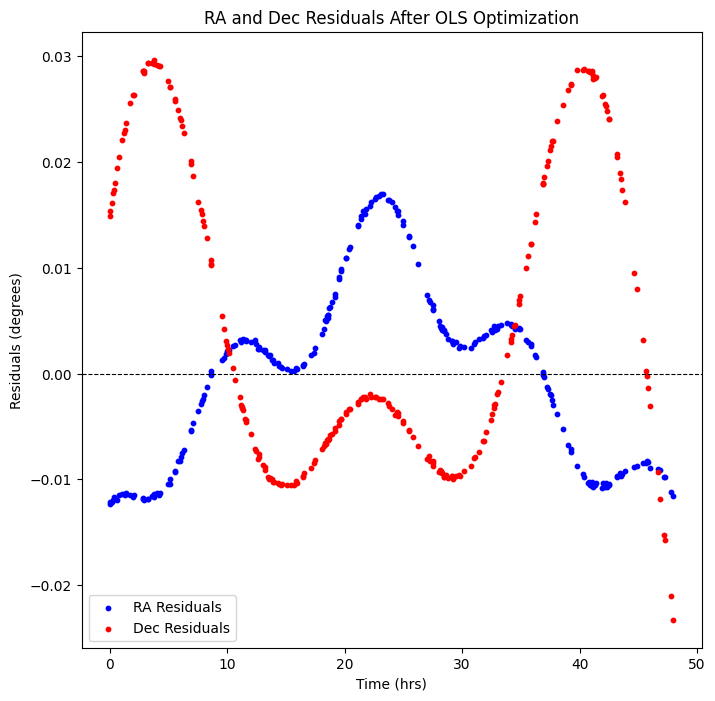

In [35]:
# Compute RA and Dec predictions from the OLS best guess
with torch.no_grad():
    trajectory_ols = odeint(pure_physics_model, best_x0_guess_ols, observation_times, method='rk4')
    ra_guess, dec_guess = calculate_ra_dec_eci(trajectory_ols)

# Plot the residuals
fig, ax = plt.subplots(figsize=(8, 8))

# Compute RA residuals accounting for circular nature (0-360 degrees)
ra_guess_deg = ra_guess.detach().numpy()
ra_obs_deg = ra_obs_noisy.detach().numpy()
ra_diff_rad = np.radians(ra_guess_deg - ra_obs_deg)
ra_residuals = np.degrees(np.arctan2(np.sin(ra_diff_rad), np.cos(ra_diff_rad)))

# Dec residuals (no circular issue)
dec_residuals = dec_guess.detach().numpy() - dec_obs_noisy.detach().numpy()

ax.scatter(observation_times/3600.0, ra_residuals, color='blue', s=10, label='RA Residuals')
ax.scatter(observation_times/3600.0, dec_residuals, color='red', s=10, label='Dec Residuals')
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax.set_xlabel('Time (hrs)')
ax.set_ylabel('Residuals (degrees)')
ax.set_title('RA and Dec Residuals After OLS Optimization')
ax.legend()
plt.show()

<br>

## PINN:

Define a simple fully connected neural network with 2 hidden layers and 100 neurons in each layer, and train until the loss stops improving

In [36]:
neural_net = MLP(hidden_layers=2, neurons_per_layer=100)
pinn = PINN(neural_net)

num_epochs = 20000
patience = 2000
counter = 0

# Start with the best OLS guess as the initial state for PINN optimization
x0_guess = torch.nn.Parameter(best_x0_guess_ols.clone().detach(), requires_grad=True)

# 2. Setup Optimizer
# We start with a smaller learning rate; x0 is very sensitive for GEO orbits
optimizer = torch.optim.Adam([
    {'params': neural_net.parameters(), 'lr': 3e-2}, # NN weights
    {'params': [x0_guess], 'lr': 5e-5}         # IC tuning (Smaller LR)
])

scheduled_lr = optim.lr_scheduler.StepLR(optimizer, step_size=250, gamma=0.98)

# Initialize variables to store the best guess
best_loss = float('inf')
best_x0 = x0_guess.clone()

for epoch in trange(num_epochs, desc="Training PINN"):
    optimizer.zero_grad()
    x0_active = x0_guess  # Unscale for physics model

    # Propagate the orbit with the current guess of initial state
    trajectory_guess = odeint(pinn, x0_active, observation_times, method='rk4')

    # Get RA and Dec at observation times
    ra_guess, dec_guess = calculate_ra_dec_eci(trajectory_guess)

    # Compute loss as Mean Squared Error between observed and guessed RA/Dec
    loss_ra = circular_mse_loss(ra_guess, ra_obs_noisy_tensor)
    loss_dec = torch.mean((dec_guess - dec_obs_noisy_tensor)**2)
    loss = loss_ra + loss_dec

    # Update best guess if current loss is lower
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_x0 = x0_guess.clone().detach()
        counter = 0  # Reset counter if improvement
    else:
        counter += 1

    # 3. IC Tuning Frequency Logic
    # If this isn't the 5th epoch, wipe the x0 gradient so it doesn't move
    if epoch % 100 != 0:
        if x0_guess.grad is not None:
            x0_guess.grad.zero_()

    # Backpropagation   
    loss.backward()
    optimizer.step()

    scheduled_lr.step()

    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}")

    if counter >= patience:
        print(f"No improvement for {patience} epochs. Stopping early at epoch {epoch+1}.")
        break

# After optimization, the best guess is stored in best_x0
print(f"Best Loss: {best_loss:.6f}")
print(f"Best Initial State Guess: {best_x0}") 

Training PINN:   0%|          | 100/20000 [02:32<7:15:23,  1.31s/it]

Epoch 100/20000, Loss: 0.000159


Training PINN:   1%|          | 200/20000 [04:55<8:32:28,  1.55s/it] 

Epoch 200/20000, Loss: 0.000151


Training PINN:   2%|▏         | 300/20000 [07:35<8:38:27,  1.58s/it] 

Epoch 300/20000, Loss: 0.000143


Training PINN:   2%|▏         | 400/20000 [10:11<8:10:52,  1.50s/it] 

Epoch 400/20000, Loss: 0.000137


Training PINN:   2%|▎         | 500/20000 [12:36<8:48:48,  1.63s/it]

Epoch 500/20000, Loss: 0.000132


Training PINN:   3%|▎         | 600/20000 [15:14<7:11:28,  1.33s/it] 

Epoch 600/20000, Loss: 0.000126


Training PINN:   4%|▎         | 700/20000 [17:34<7:32:30,  1.41s/it] 

Epoch 700/20000, Loss: 0.000120


Training PINN:   4%|▍         | 800/20000 [19:59<7:54:33,  1.48s/it]

Epoch 800/20000, Loss: 0.000116


Training PINN:   4%|▍         | 900/20000 [22:32<7:19:21,  1.38s/it] 

Epoch 900/20000, Loss: 0.000113


Training PINN:   5%|▌         | 1000/20000 [25:05<6:59:10,  1.32s/it]

Epoch 1000/20000, Loss: 0.000110


Training PINN:   6%|▌         | 1100/20000 [27:32<9:23:48,  1.79s/it] 

Epoch 1100/20000, Loss: 0.000107


Training PINN:   6%|▌         | 1200/20000 [30:11<7:43:07,  1.48s/it] 

Epoch 1200/20000, Loss: 0.000105


Training PINN:   6%|▋         | 1300/20000 [32:36<6:53:09,  1.33s/it] 

Epoch 1300/20000, Loss: 0.000103


Training PINN:   7%|▋         | 1400/20000 [34:47<6:31:15,  1.26s/it]

Epoch 1400/20000, Loss: 0.000101


Training PINN:   8%|▊         | 1500/20000 [36:54<6:30:46,  1.27s/it]

Epoch 1500/20000, Loss: 0.000099


Training PINN:   8%|▊         | 1600/20000 [39:22<7:02:07,  1.38s/it] 

Epoch 1600/20000, Loss: 0.000097


Training PINN:   8%|▊         | 1700/20000 [41:46<6:53:54,  1.36s/it]

Epoch 1700/20000, Loss: 0.000095


Training PINN:   9%|▉         | 1800/20000 [43:58<6:05:35,  1.21s/it]

Epoch 1800/20000, Loss: 0.000094


Training PINN:  10%|▉         | 1900/20000 [45:55<5:47:47,  1.15s/it]

Epoch 1900/20000, Loss: 0.000093


Training PINN:  10%|█         | 2000/20000 [47:52<5:53:50,  1.18s/it]

Epoch 2000/20000, Loss: 0.000090


Training PINN:  10%|█         | 2100/20000 [49:49<5:46:19,  1.16s/it]

Epoch 2100/20000, Loss: 0.000088


Training PINN:  11%|█         | 2200/20000 [51:45<5:44:54,  1.16s/it]

Epoch 2200/20000, Loss: 0.000086


Training PINN:  12%|█▏        | 2300/20000 [53:41<5:44:13,  1.17s/it]

Epoch 2300/20000, Loss: 0.000084


Training PINN:  12%|█▏        | 2400/20000 [55:37<5:35:11,  1.14s/it]

Epoch 2400/20000, Loss: 0.000082


Training PINN:  12%|█▎        | 2500/20000 [57:33<5:40:41,  1.17s/it]

Epoch 2500/20000, Loss: 0.000080


Training PINN:  13%|█▎        | 2600/20000 [59:29<5:36:22,  1.16s/it]

Epoch 2600/20000, Loss: 0.000078


Training PINN:  14%|█▎        | 2700/20000 [1:01:24<5:31:55,  1.15s/it]

Epoch 2700/20000, Loss: 0.000077


Training PINN:  14%|█▍        | 2800/20000 [1:03:20<5:40:27,  1.19s/it]

Epoch 2800/20000, Loss: 0.000075


Training PINN:  14%|█▍        | 2900/20000 [1:05:17<5:25:28,  1.14s/it]

Epoch 2900/20000, Loss: 0.000084


Training PINN:  15%|█▌        | 3000/20000 [1:07:13<5:24:08,  1.14s/it]

Epoch 3000/20000, Loss: 0.000072


Training PINN:  16%|█▌        | 3100/20000 [1:09:09<5:32:07,  1.18s/it]

Epoch 3100/20000, Loss: 0.000071


Training PINN:  16%|█▌        | 3200/20000 [1:11:05<5:25:33,  1.16s/it]

Epoch 3200/20000, Loss: 0.000069


Training PINN:  16%|█▋        | 3300/20000 [1:13:01<5:21:51,  1.16s/it]

Epoch 3300/20000, Loss: 0.000069


Training PINN:  17%|█▋        | 3400/20000 [1:14:58<5:22:26,  1.17s/it]

Epoch 3400/20000, Loss: 0.000068


Training PINN:  18%|█▊        | 3500/20000 [1:16:53<5:15:54,  1.15s/it]

Epoch 3500/20000, Loss: 0.000066


Training PINN:  18%|█▊        | 3600/20000 [1:18:50<5:24:08,  1.19s/it]

Epoch 3600/20000, Loss: 0.000065


Training PINN:  18%|█▊        | 3700/20000 [1:20:47<5:19:25,  1.18s/it]

Epoch 3700/20000, Loss: 0.000064


Training PINN:  19%|█▉        | 3800/20000 [1:22:42<5:10:10,  1.15s/it]

Epoch 3800/20000, Loss: 0.000063


Training PINN:  20%|█▉        | 3900/20000 [1:24:38<5:11:12,  1.16s/it]

Epoch 3900/20000, Loss: 0.000062


Training PINN:  20%|██        | 4000/20000 [1:26:34<5:13:32,  1.18s/it]

Epoch 4000/20000, Loss: 0.000061


Training PINN:  20%|██        | 4100/20000 [1:28:30<5:05:48,  1.15s/it]

Epoch 4100/20000, Loss: 0.000060


Training PINN:  21%|██        | 4200/20000 [1:30:26<5:10:49,  1.18s/it]

Epoch 4200/20000, Loss: 0.000059


Training PINN:  22%|██▏       | 4300/20000 [1:32:22<5:03:30,  1.16s/it]

Epoch 4300/20000, Loss: 0.000059


Training PINN:  22%|██▏       | 4400/20000 [1:34:19<5:00:23,  1.16s/it]

Epoch 4400/20000, Loss: 0.000058


Training PINN:  22%|██▎       | 4500/20000 [1:36:15<5:03:36,  1.18s/it]

Epoch 4500/20000, Loss: 0.000064


Training PINN:  23%|██▎       | 4600/20000 [1:38:11<4:54:45,  1.15s/it]

Epoch 4600/20000, Loss: 0.000057


Training PINN:  24%|██▎       | 4700/20000 [1:40:06<4:51:21,  1.14s/it]

Epoch 4700/20000, Loss: 0.000056


Training PINN:  24%|██▍       | 4800/20000 [1:42:03<4:55:30,  1.17s/it]

Epoch 4800/20000, Loss: 0.000055


Training PINN:  24%|██▍       | 4900/20000 [1:43:58<4:54:27,  1.17s/it]

Epoch 4900/20000, Loss: 0.000054


Training PINN:  25%|██▌       | 5000/20000 [1:45:54<4:47:37,  1.15s/it]

Epoch 5000/20000, Loss: 0.000054


Training PINN:  26%|██▌       | 5100/20000 [1:47:50<4:43:44,  1.14s/it]

Epoch 5100/20000, Loss: 0.000052


Training PINN:  26%|██▌       | 5200/20000 [1:49:46<4:43:39,  1.15s/it]

Epoch 5200/20000, Loss: 0.000052


Training PINN:  26%|██▋       | 5300/20000 [1:51:42<4:46:27,  1.17s/it]

Epoch 5300/20000, Loss: 0.000051


Training PINN:  27%|██▋       | 5400/20000 [1:53:37<4:45:11,  1.17s/it]

Epoch 5400/20000, Loss: 0.000050


Training PINN:  28%|██▊       | 5500/20000 [1:55:33<4:42:07,  1.17s/it]

Epoch 5500/20000, Loss: 0.000050


Training PINN:  28%|██▊       | 5600/20000 [1:57:29<4:33:39,  1.14s/it]

Epoch 5600/20000, Loss: 0.000049


Training PINN:  28%|██▊       | 5700/20000 [1:59:24<4:34:37,  1.15s/it]

Epoch 5700/20000, Loss: 0.000049


Training PINN:  29%|██▉       | 5800/20000 [2:01:20<4:33:05,  1.15s/it]

Epoch 5800/20000, Loss: 0.000048


Training PINN:  30%|██▉       | 5900/20000 [2:03:16<4:33:52,  1.17s/it]

Epoch 5900/20000, Loss: 0.000048


Training PINN:  30%|███       | 6000/20000 [2:05:13<4:30:02,  1.16s/it]

Epoch 6000/20000, Loss: 0.000047


Training PINN:  30%|███       | 6100/20000 [2:07:08<4:25:03,  1.14s/it]

Epoch 6100/20000, Loss: 0.000047


Training PINN:  31%|███       | 6200/20000 [2:09:03<4:23:27,  1.15s/it]

Epoch 6200/20000, Loss: 0.000046


Training PINN:  32%|███▏      | 6300/20000 [2:10:59<4:20:23,  1.14s/it]

Epoch 6300/20000, Loss: 0.000046


Training PINN:  32%|███▏      | 6400/20000 [2:12:54<4:23:27,  1.16s/it]

Epoch 6400/20000, Loss: 0.000045


Training PINN:  32%|███▎      | 6500/20000 [2:14:49<4:20:48,  1.16s/it]

Epoch 6500/20000, Loss: 0.000045


Training PINN:  33%|███▎      | 6600/20000 [2:16:45<4:14:55,  1.14s/it]

Epoch 6600/20000, Loss: 0.000044


Training PINN:  34%|███▎      | 6700/20000 [2:18:40<4:16:02,  1.16s/it]

Epoch 6700/20000, Loss: 0.000044


Training PINN:  34%|███▍      | 6800/20000 [2:20:36<4:11:31,  1.14s/it]

Epoch 6800/20000, Loss: 0.000043


Training PINN:  34%|███▍      | 6900/20000 [2:22:31<4:13:36,  1.16s/it]

Epoch 6900/20000, Loss: 0.000043


Training PINN:  35%|███▌      | 7000/20000 [2:24:26<4:12:41,  1.17s/it]

Epoch 7000/20000, Loss: 0.000042


Training PINN:  36%|███▌      | 7100/20000 [2:26:22<4:08:19,  1.16s/it]

Epoch 7100/20000, Loss: 0.000042


Training PINN:  36%|███▌      | 7200/20000 [2:28:17<4:03:54,  1.14s/it]

Epoch 7200/20000, Loss: 0.000042


Training PINN:  36%|███▋      | 7300/20000 [2:30:12<4:02:38,  1.15s/it]

Epoch 7300/20000, Loss: 0.000041


Training PINN:  37%|███▋      | 7400/20000 [2:32:08<4:00:00,  1.14s/it]

Epoch 7400/20000, Loss: 0.000041


Training PINN:  38%|███▊      | 7500/20000 [2:34:04<4:02:45,  1.17s/it]

Epoch 7500/20000, Loss: 0.000041


Training PINN:  38%|███▊      | 7600/20000 [2:35:59<3:56:08,  1.14s/it]

Epoch 7600/20000, Loss: 0.000040


Training PINN:  38%|███▊      | 7700/20000 [2:37:55<4:06:28,  1.20s/it]

Epoch 7700/20000, Loss: 0.000040


Training PINN:  39%|███▉      | 7800/20000 [2:39:51<3:53:57,  1.15s/it]

Epoch 7800/20000, Loss: 0.000040


Training PINN:  40%|███▉      | 7900/20000 [2:41:46<3:51:05,  1.15s/it]

Epoch 7900/20000, Loss: 0.000039


Training PINN:  40%|████      | 8000/20000 [2:43:42<3:50:40,  1.15s/it]

Epoch 8000/20000, Loss: 0.000039


Training PINN:  40%|████      | 8100/20000 [2:45:37<3:51:51,  1.17s/it]

Epoch 8100/20000, Loss: 0.000039


Training PINN:  41%|████      | 8200/20000 [2:47:33<3:49:18,  1.17s/it]

Epoch 8200/20000, Loss: 0.000038


Training PINN:  42%|████▏     | 8300/20000 [2:49:29<3:42:08,  1.14s/it]

Epoch 8300/20000, Loss: 0.000038


Training PINN:  42%|████▏     | 8400/20000 [2:51:24<3:43:01,  1.15s/it]

Epoch 8400/20000, Loss: 0.000038


Training PINN:  42%|████▎     | 8500/20000 [2:53:19<3:37:02,  1.13s/it]

Epoch 8500/20000, Loss: 0.000038


Training PINN:  43%|████▎     | 8600/20000 [2:55:15<3:41:15,  1.16s/it]

Epoch 8600/20000, Loss: 0.000038


Training PINN:  44%|████▎     | 8700/20000 [2:57:10<3:37:12,  1.15s/it]

Epoch 8700/20000, Loss: 0.000037


Training PINN:  44%|████▍     | 8800/20000 [2:59:06<3:34:43,  1.15s/it]

Epoch 8800/20000, Loss: 0.000037


Training PINN:  44%|████▍     | 8900/20000 [3:01:01<3:32:34,  1.15s/it]

Epoch 8900/20000, Loss: 0.000037


Training PINN:  45%|████▌     | 9000/20000 [3:02:57<3:31:44,  1.15s/it]

Epoch 9000/20000, Loss: 0.000037


Training PINN:  46%|████▌     | 9100/20000 [3:04:52<3:27:49,  1.14s/it]

Epoch 9100/20000, Loss: 0.000037


Training PINN:  46%|████▌     | 9200/20000 [3:06:47<3:29:24,  1.16s/it]

Epoch 9200/20000, Loss: 0.000036


Training PINN:  46%|████▋     | 9300/20000 [3:08:43<3:28:22,  1.17s/it]

Epoch 9300/20000, Loss: 0.000036


Training PINN:  47%|████▋     | 9400/20000 [3:10:38<3:24:32,  1.16s/it]

Epoch 9400/20000, Loss: 0.000036


Training PINN:  48%|████▊     | 9500/20000 [3:12:34<3:19:42,  1.14s/it]

Epoch 9500/20000, Loss: 0.000036


Training PINN:  48%|████▊     | 9600/20000 [3:14:29<3:17:52,  1.14s/it]

Epoch 9600/20000, Loss: 0.000035


Training PINN:  48%|████▊     | 9700/20000 [3:16:24<3:22:15,  1.18s/it]

Epoch 9700/20000, Loss: 0.000035


Training PINN:  49%|████▉     | 9800/20000 [3:18:19<3:16:51,  1.16s/it]

Epoch 9800/20000, Loss: 0.000035


Training PINN:  50%|████▉     | 9900/20000 [3:20:14<3:13:01,  1.15s/it]

Epoch 9900/20000, Loss: 0.000035


Training PINN:  50%|█████     | 10000/20000 [3:22:10<3:14:42,  1.17s/it]

Epoch 10000/20000, Loss: 0.000035


Training PINN:  50%|█████     | 10100/20000 [3:24:05<3:09:11,  1.15s/it]

Epoch 10100/20000, Loss: 0.000035


Training PINN:  51%|█████     | 10200/20000 [3:26:01<3:14:51,  1.19s/it]

Epoch 10200/20000, Loss: 0.000034


Training PINN:  52%|█████▏    | 10300/20000 [3:27:56<3:08:16,  1.16s/it]

Epoch 10300/20000, Loss: 0.000034


Training PINN:  52%|█████▏    | 10400/20000 [3:29:51<3:05:14,  1.16s/it]

Epoch 10400/20000, Loss: 0.000034


Training PINN:  52%|█████▎    | 10500/20000 [3:31:46<3:04:49,  1.17s/it]

Epoch 10500/20000, Loss: 0.000034


Training PINN:  53%|█████▎    | 10600/20000 [3:33:41<2:58:19,  1.14s/it]

Epoch 10600/20000, Loss: 0.000034


Training PINN:  54%|█████▎    | 10700/20000 [3:35:37<2:56:29,  1.14s/it]

Epoch 10700/20000, Loss: 0.000034


Training PINN:  54%|█████▍    | 10800/20000 [3:37:32<3:01:50,  1.19s/it]

Epoch 10800/20000, Loss: 0.000033


Training PINN:  55%|█████▍    | 10900/20000 [3:39:28<2:55:25,  1.16s/it]

Epoch 10900/20000, Loss: 0.000033


Training PINN:  55%|█████▌    | 11000/20000 [3:41:23<2:54:23,  1.16s/it]

Epoch 11000/20000, Loss: 0.000033


Training PINN:  56%|█████▌    | 11100/20000 [3:43:18<2:51:49,  1.16s/it]

Epoch 11100/20000, Loss: 0.000033


Training PINN:  56%|█████▌    | 11200/20000 [3:45:13<2:46:53,  1.14s/it]

Epoch 11200/20000, Loss: 0.000033


Training PINN:  56%|█████▋    | 11300/20000 [3:47:09<2:50:13,  1.17s/it]

Epoch 11300/20000, Loss: 0.000033


Training PINN:  57%|█████▋    | 11400/20000 [3:49:06<2:45:16,  1.15s/it]

Epoch 11400/20000, Loss: 0.000033


Training PINN:  57%|█████▊    | 11500/20000 [3:51:01<2:44:18,  1.16s/it]

Epoch 11500/20000, Loss: 0.000033


Training PINN:  58%|█████▊    | 11600/20000 [3:52:56<2:41:01,  1.15s/it]

Epoch 11600/20000, Loss: 0.000033


Training PINN:  58%|█████▊    | 11700/20000 [3:54:51<2:39:02,  1.15s/it]

Epoch 11700/20000, Loss: 0.000032


Training PINN:  59%|█████▉    | 11800/20000 [3:56:46<2:35:21,  1.14s/it]

Epoch 11800/20000, Loss: 0.000032


Training PINN:  60%|█████▉    | 11900/20000 [3:58:41<2:39:02,  1.18s/it]

Epoch 11900/20000, Loss: 0.000032


Training PINN:  60%|██████    | 12000/20000 [4:00:36<2:34:30,  1.16s/it]

Epoch 12000/20000, Loss: 0.000032


Training PINN:  60%|██████    | 12100/20000 [4:02:31<2:29:37,  1.14s/it]

Epoch 12100/20000, Loss: 0.000032


Training PINN:  61%|██████    | 12200/20000 [4:04:26<2:27:46,  1.14s/it]

Epoch 12200/20000, Loss: 0.000032


Training PINN:  62%|██████▏   | 12300/20000 [4:06:21<2:25:10,  1.13s/it]

Epoch 12300/20000, Loss: 0.000032


Training PINN:  62%|██████▏   | 12400/20000 [4:08:17<2:23:16,  1.13s/it]

Epoch 12400/20000, Loss: 0.000036


Training PINN:  62%|██████▎   | 12500/20000 [4:10:12<2:24:27,  1.16s/it]

Epoch 12500/20000, Loss: 0.000032


Training PINN:  63%|██████▎   | 12600/20000 [4:12:08<2:23:46,  1.17s/it]

Epoch 12600/20000, Loss: 0.000032


Training PINN:  64%|██████▎   | 12700/20000 [4:14:03<2:19:56,  1.15s/it]

Epoch 12700/20000, Loss: 0.000031


Training PINN:  64%|██████▍   | 12800/20000 [4:15:58<2:16:35,  1.14s/it]

Epoch 12800/20000, Loss: 0.000031


Training PINN:  64%|██████▍   | 12900/20000 [4:17:54<2:16:00,  1.15s/it]

Epoch 12900/20000, Loss: 0.000031


Training PINN:  65%|██████▌   | 13000/20000 [4:19:49<2:15:00,  1.16s/it]

Epoch 13000/20000, Loss: 0.000031


Training PINN:  66%|██████▌   | 13100/20000 [4:21:44<2:13:15,  1.16s/it]

Epoch 13100/20000, Loss: 0.000031


Training PINN:  66%|██████▌   | 13200/20000 [4:23:40<2:09:45,  1.14s/it]

Epoch 13200/20000, Loss: 0.000031


Training PINN:  66%|██████▋   | 13300/20000 [4:25:35<2:07:32,  1.14s/it]

Epoch 13300/20000, Loss: 0.000031


Training PINN:  67%|██████▋   | 13400/20000 [4:27:30<2:08:36,  1.17s/it]

Epoch 13400/20000, Loss: 0.000031


Training PINN:  68%|██████▊   | 13500/20000 [4:29:26<2:05:48,  1.16s/it]

Epoch 13500/20000, Loss: 0.000031


Training PINN:  68%|██████▊   | 13600/20000 [4:31:21<2:02:56,  1.15s/it]

Epoch 13600/20000, Loss: 0.000030


Training PINN:  68%|██████▊   | 13700/20000 [4:33:16<2:01:47,  1.16s/it]

Epoch 13700/20000, Loss: 0.000030


Training PINN:  69%|██████▉   | 13800/20000 [4:35:11<1:59:26,  1.16s/it]

Epoch 13800/20000, Loss: 0.000030


Training PINN:  70%|██████▉   | 13900/20000 [4:37:06<1:56:59,  1.15s/it]

Epoch 13900/20000, Loss: 0.000030


Training PINN:  70%|███████   | 14000/20000 [4:39:02<1:55:31,  1.16s/it]

Epoch 14000/20000, Loss: 0.000030


Training PINN:  70%|███████   | 14100/20000 [4:40:57<1:57:02,  1.19s/it]

Epoch 14100/20000, Loss: 0.000030


Training PINN:  71%|███████   | 14200/20000 [4:42:52<1:51:21,  1.15s/it]

Epoch 14200/20000, Loss: 0.000030


Training PINN:  72%|███████▏  | 14300/20000 [4:44:48<1:48:51,  1.15s/it]

Epoch 14300/20000, Loss: 0.000030


Training PINN:  72%|███████▏  | 14400/20000 [4:46:42<1:45:59,  1.14s/it]

Epoch 14400/20000, Loss: 0.000030


Training PINN:  72%|███████▎  | 14500/20000 [4:48:38<1:44:00,  1.13s/it]

Epoch 14500/20000, Loss: 0.000030


Training PINN:  73%|███████▎  | 14600/20000 [4:50:34<1:41:51,  1.13s/it]

Epoch 14600/20000, Loss: 0.000030


Training PINN:  74%|███████▎  | 14700/20000 [4:52:29<1:42:14,  1.16s/it]

Epoch 14700/20000, Loss: 0.000030


Training PINN:  74%|███████▍  | 14800/20000 [4:54:24<1:40:09,  1.16s/it]

Epoch 14800/20000, Loss: 0.000030


Training PINN:  74%|███████▍  | 14900/20000 [4:56:20<1:35:46,  1.13s/it]

Epoch 14900/20000, Loss: 0.000029


Training PINN:  75%|███████▌  | 15000/20000 [4:58:15<1:35:34,  1.15s/it]

Epoch 15000/20000, Loss: 0.000029


Training PINN:  76%|███████▌  | 15100/20000 [5:00:11<1:33:09,  1.14s/it]

Epoch 15100/20000, Loss: 0.000029


Training PINN:  76%|███████▌  | 15200/20000 [5:02:06<1:34:25,  1.18s/it]

Epoch 15200/20000, Loss: 0.000029


Training PINN:  76%|███████▋  | 15300/20000 [5:04:01<1:33:05,  1.19s/it]

Epoch 15300/20000, Loss: 0.000029


Training PINN:  77%|███████▋  | 15400/20000 [5:05:57<1:28:15,  1.15s/it]

Epoch 15400/20000, Loss: 0.000029


Training PINN:  78%|███████▊  | 15500/20000 [5:07:53<1:26:11,  1.15s/it]

Epoch 15500/20000, Loss: 0.000029


Training PINN:  78%|███████▊  | 15600/20000 [5:09:49<1:23:04,  1.13s/it]

Epoch 15600/20000, Loss: 0.000029


Training PINN:  78%|███████▊  | 15700/20000 [5:11:45<1:21:47,  1.14s/it]

Epoch 15700/20000, Loss: 0.000029


Training PINN:  79%|███████▉  | 15800/20000 [5:13:40<1:20:56,  1.16s/it]

Epoch 15800/20000, Loss: 0.000029


Training PINN:  80%|███████▉  | 15900/20000 [5:15:36<1:22:00,  1.20s/it]

Epoch 15900/20000, Loss: 0.000029


Training PINN:  80%|████████  | 16000/20000 [5:17:32<1:17:20,  1.16s/it]

Epoch 16000/20000, Loss: 0.000029


Training PINN:  80%|████████  | 16100/20000 [5:19:28<1:15:03,  1.15s/it]

Epoch 16100/20000, Loss: 0.000029


Training PINN:  81%|████████  | 16200/20000 [5:21:24<1:12:16,  1.14s/it]

Epoch 16200/20000, Loss: 0.000029


Training PINN:  82%|████████▏ | 16300/20000 [5:23:20<1:12:17,  1.17s/it]

Epoch 16300/20000, Loss: 0.000029


Training PINN:  82%|████████▏ | 16400/20000 [5:25:15<1:09:27,  1.16s/it]

Epoch 16400/20000, Loss: 0.000029


Training PINN:  82%|████████▎ | 16500/20000 [5:27:11<1:06:56,  1.15s/it]

Epoch 16500/20000, Loss: 0.000028


Training PINN:  83%|████████▎ | 16600/20000 [5:29:07<1:04:53,  1.15s/it]

Epoch 16600/20000, Loss: 0.000028


Training PINN:  84%|████████▎ | 16700/20000 [5:31:02<1:02:46,  1.14s/it]

Epoch 16700/20000, Loss: 0.000028


Training PINN:  84%|████████▍ | 16800/20000 [5:32:58<1:03:36,  1.19s/it]

Epoch 16800/20000, Loss: 0.000028


Training PINN:  84%|████████▍ | 16900/20000 [5:34:54<1:00:50,  1.18s/it]

Epoch 16900/20000, Loss: 0.000028


Training PINN:  85%|████████▌ | 17000/20000 [5:36:50<57:25,  1.15s/it]  

Epoch 17000/20000, Loss: 0.000028


Training PINN:  86%|████████▌ | 17100/20000 [5:38:46<56:34,  1.17s/it]

Epoch 17100/20000, Loss: 0.000028


Training PINN:  86%|████████▌ | 17200/20000 [5:40:41<53:45,  1.15s/it]

Epoch 17200/20000, Loss: 0.000028


Training PINN:  86%|████████▋ | 17300/20000 [5:42:37<51:49,  1.15s/it]

Epoch 17300/20000, Loss: 0.000028


Training PINN:  87%|████████▋ | 17400/20000 [5:44:33<50:58,  1.18s/it]

Epoch 17400/20000, Loss: 0.000028


Training PINN:  88%|████████▊ | 17500/20000 [5:46:28<48:15,  1.16s/it]

Epoch 17500/20000, Loss: 0.000028


Training PINN:  88%|████████▊ | 17600/20000 [5:48:24<45:37,  1.14s/it]

Epoch 17600/20000, Loss: 0.000028


Training PINN:  88%|████████▊ | 17700/20000 [5:50:20<43:47,  1.14s/it]

Epoch 17700/20000, Loss: 0.000028


Training PINN:  89%|████████▉ | 17800/20000 [5:52:16<42:38,  1.16s/it]

Epoch 17800/20000, Loss: 0.000028


Training PINN:  90%|████████▉ | 17900/20000 [5:54:12<40:04,  1.14s/it]

Epoch 17900/20000, Loss: 0.000028


Training PINN:  90%|█████████ | 18000/20000 [5:56:07<39:22,  1.18s/it]

Epoch 18000/20000, Loss: 0.000028


Training PINN:  90%|█████████ | 18100/20000 [5:58:03<37:05,  1.17s/it]

Epoch 18100/20000, Loss: 0.000028


Training PINN:  91%|█████████ | 18200/20000 [5:59:59<34:20,  1.14s/it]

Epoch 18200/20000, Loss: 0.000028


Training PINN:  92%|█████████▏| 18300/20000 [6:01:54<33:05,  1.17s/it]

Epoch 18300/20000, Loss: 0.000027


Training PINN:  92%|█████████▏| 18400/20000 [6:03:50<30:21,  1.14s/it]

Epoch 18400/20000, Loss: 0.000027


Training PINN:  92%|█████████▎| 18500/20000 [6:05:46<29:07,  1.17s/it]

Epoch 18500/20000, Loss: 0.000027


Training PINN:  93%|█████████▎| 18600/20000 [6:07:42<27:06,  1.16s/it]

Epoch 18600/20000, Loss: 0.000027


Training PINN:  94%|█████████▎| 18700/20000 [6:09:38<25:07,  1.16s/it]

Epoch 18700/20000, Loss: 0.000027


Training PINN:  94%|█████████▍| 18800/20000 [6:11:33<22:52,  1.14s/it]

Epoch 18800/20000, Loss: 0.000027


Training PINN:  94%|█████████▍| 18900/20000 [6:13:29<21:00,  1.15s/it]

Epoch 18900/20000, Loss: 0.000027


Training PINN:  95%|█████████▌| 19000/20000 [6:15:25<18:58,  1.14s/it]

Epoch 19000/20000, Loss: 0.000027


Training PINN:  96%|█████████▌| 19100/20000 [6:17:21<17:40,  1.18s/it]

Epoch 19100/20000, Loss: 0.000027


Training PINN:  96%|█████████▌| 19200/20000 [6:19:17<15:29,  1.16s/it]

Epoch 19200/20000, Loss: 0.000027


Training PINN:  96%|█████████▋| 19300/20000 [6:21:12<13:23,  1.15s/it]

Epoch 19300/20000, Loss: 0.000027


Training PINN:  97%|█████████▋| 19400/20000 [6:23:08<11:34,  1.16s/it]

Epoch 19400/20000, Loss: 0.000027


Training PINN:  98%|█████████▊| 19500/20000 [6:25:03<09:32,  1.14s/it]

Epoch 19500/20000, Loss: 0.000027


Training PINN:  98%|█████████▊| 19600/20000 [6:26:59<07:47,  1.17s/it]

Epoch 19600/20000, Loss: 0.000027


Training PINN:  98%|█████████▊| 19700/20000 [6:28:55<05:53,  1.18s/it]

Epoch 19700/20000, Loss: 0.000027


Training PINN:  99%|█████████▉| 19800/20000 [6:30:50<03:51,  1.16s/it]

Epoch 19800/20000, Loss: 0.000027


Training PINN: 100%|█████████▉| 19900/20000 [6:32:47<01:53,  1.14s/it]

Epoch 19900/20000, Loss: 0.000027


Training PINN: 100%|██████████| 20000/20000 [6:34:42<00:00,  1.18s/it]

Epoch 20000/20000, Loss: 0.000027
Best Loss: 0.000027
Best Initial State Guess: tensor([ 4.2160e+07, -9.0248e+03,  1.0928e+04,  8.0363e-01,  3.0736e+03,
         8.1673e+01], dtype=torch.float64)


Take the final result and re-propagate the trajectory

In [49]:
with torch.no_grad():
    trajectory_guess = odeint(pinn, best_x0, observation_times, method='rk4')
    ra_guess_pinn, dec_guess_pinn = calculate_ra_dec_eci(trajectory_guess)

Now plot the RA, DEC residuals obtained using the PINN:

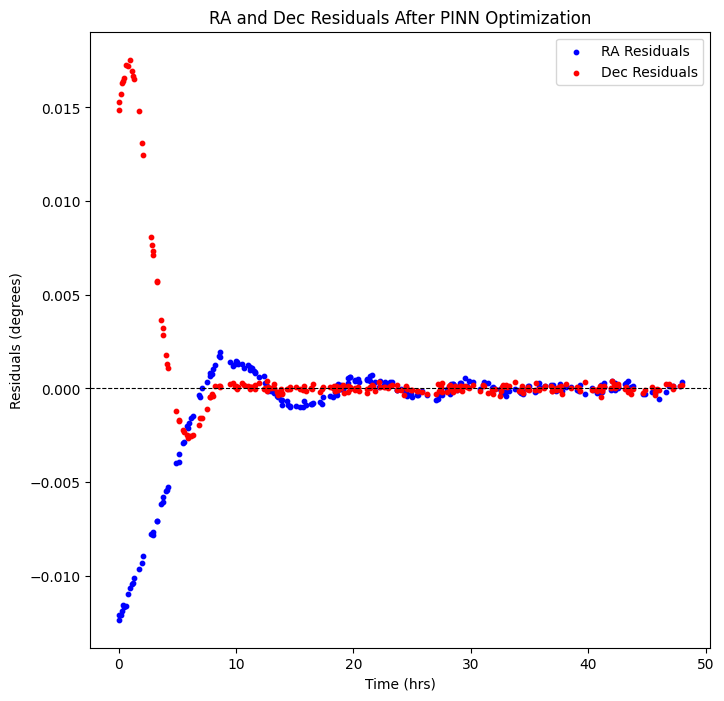

In [50]:
# plot the residuals from the PINN fit
fig, ax = plt.subplots(figsize=(8, 8))
# Compute RA residuals accounting for circular nature (0-360 degrees)
ra_guess_deg = ra_guess_pinn.detach().numpy()
ra_obs_deg = ra_obs_noisy.detach().numpy()
ra_diff_rad = np.radians(ra_guess_deg - ra_obs_deg)
ra_residuals = np.degrees(np.arctan2(np.sin(ra_diff_rad), np.cos(ra_diff_rad)))
# Dec residuals (no circular issue)
dec_residuals = dec_guess_pinn.detach().numpy() - dec_obs_noisy.detach().numpy()
ax.scatter(observation_times/3600.0, ra_residuals, color='blue', s=10, label='RA Residuals')
ax.scatter(observation_times/3600.0, dec_residuals, color='red', s=10, label='Dec Residuals')
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax.set_xlabel('Time (hrs)')
ax.set_ylabel('Residuals (degrees)')
ax.set_title('RA and Dec Residuals After PINN Optimization')
ax.legend()
plt.show()

Plot the estimated thrust accelerations:

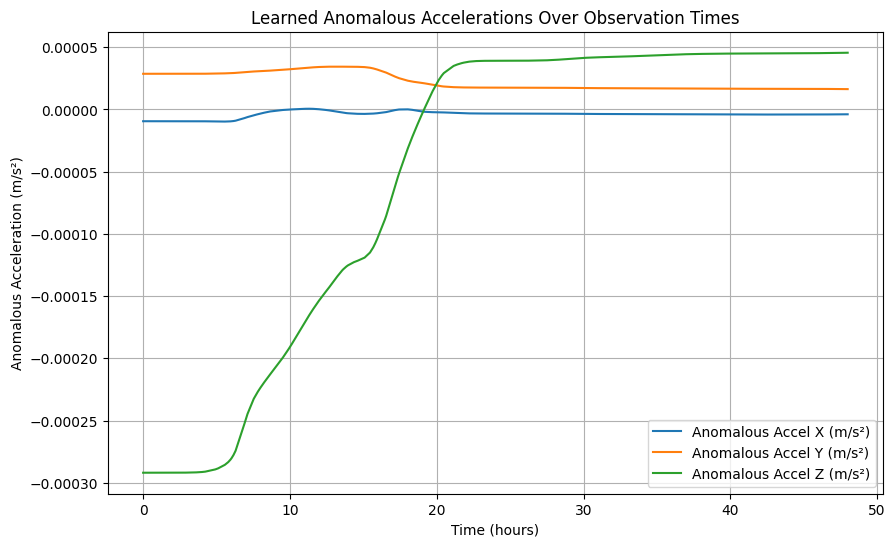

In [51]:
# Get x, y, z components of the anomalous acceleration from the neural network over the observation times
anomalous_accels = torch.stack([neural_net(ti, odeint(pinn, best_x0, torch.tensor([ti], dtype=torch.float64), method='rk4')[-1]) for ti in observation_times])

# Plot the anomalous accelerations
plt.figure(figsize=(10, 6))
plt.plot(observation_times.numpy()/3600, anomalous_accels[:,0].detach().numpy(), label='Anomalous Accel X (m/s²)')
plt.plot(observation_times.numpy()/3600, anomalous_accels[:,1].detach().numpy(), label='Anomalous Accel Y (m/s²)')
plt.plot(observation_times.numpy()/3600, anomalous_accels[:,2].detach().numpy(), label='Anomalous Accel Z (m/s²)')
plt.xlabel('Time (hours)')
plt.ylabel('Anomalous Acceleration (m/s²)')
plt.title('Learned Anomalous Accelerations Over Observation Times')
plt.legend()
plt.grid()
plt.show()

Compare the OLS and PINN residuals

In [52]:
# Compute RA and Dec predictions from the OLS best guess
with torch.no_grad():
    trajectory_ols = odeint(pure_physics_model, best_x0_guess_ols, observation_times, method='rk4')
    ra_ols, dec_ols = calculate_ra_dec_eci(trajectory_ols)

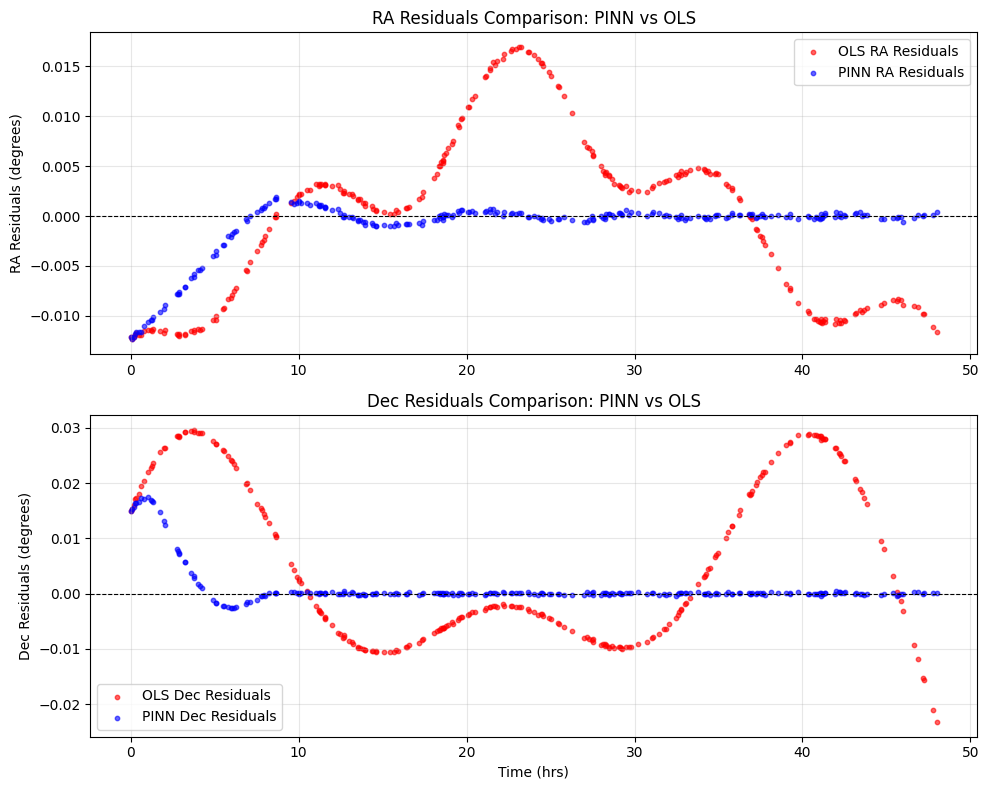

In [56]:
# Plot RA and DEC residuals for PINN result vs OLS
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Compute RA residuals for OLS (accounting for circular wrap-around)
ra_ols_deg = ra_ols.detach().numpy()
ra_diff_rad_ols = np.radians(ra_ols_deg - ra_obs_deg)
ra_residuals_ols = np.degrees(np.arctan2(np.sin(ra_diff_rad_ols), np.cos(ra_diff_rad_ols)))

# Compute RA residuals for PINN (accounting for circular wrap-around)
ra_pinn_deg = ra_guess_pinn.detach().numpy()
ra_diff_rad_pinn = np.radians(ra_pinn_deg - ra_obs_deg)
ra_residuals_pinn = np.degrees(np.arctan2(np.sin(ra_diff_rad_pinn), np.cos(ra_diff_rad_pinn)))

# RA plot
ax1.scatter(observation_times/3600.0, ra_residuals_ols, color='red', s=10, label='OLS RA Residuals', alpha=0.6)
ax1.scatter(observation_times/3600.0, ra_residuals_pinn, color='blue', s=10, label='PINN RA Residuals', alpha=0.6)
ax1.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax1.set_ylabel('RA Residuals (degrees)')
ax1.set_title('RA Residuals Comparison: PINN vs OLS')
ax1.legend()
ax1.grid(True, alpha=0.3)

# DEC plot
dec_residuals_ols = dec_ols.detach().numpy() - dec_obs_noisy.detach().numpy()
dec_residuals_pinn = dec_guess_pinn.detach().numpy() - dec_obs_noisy.detach().numpy()

ax2.scatter(observation_times/3600.0, dec_residuals_ols, color='red', s=10, label='OLS Dec Residuals', alpha=0.6)
ax2.scatter(observation_times/3600.0, dec_residuals_pinn, color='blue', s=10, label='PINN Dec Residuals', alpha=0.6)
ax2.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax2.set_xlabel('Time (hrs)')
ax2.set_ylabel('Dec Residuals (degrees)')
ax2.set_title('Dec Residuals Comparison: PINN vs OLS')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
  

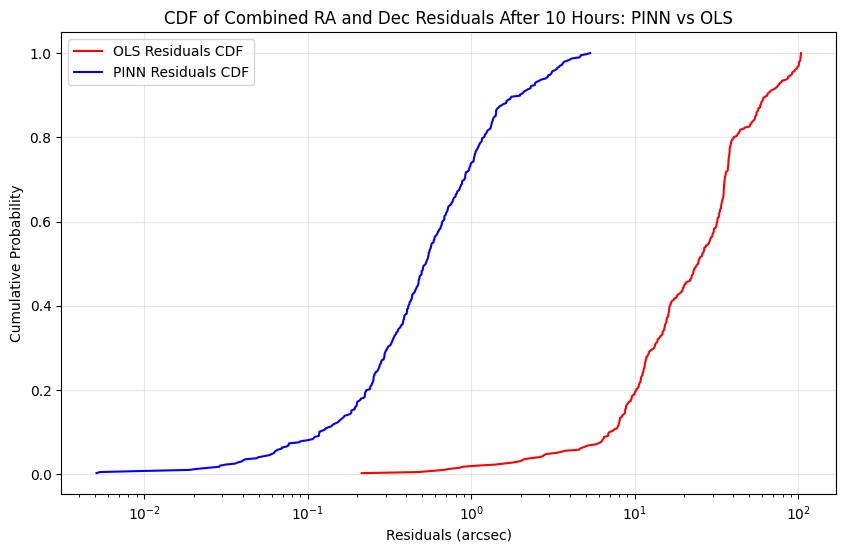

In [67]:
# CDF of RA and Dec residuals for OLS and PINN
plt.figure(figsize=(10, 6))

# Pool RA and Dec residuals together and take absolute values
ra_residuals_ols_pooled = np.concatenate([ra_residuals_ols, dec_residuals_ols])
ra_residuals_pinn_pooled = np.concatenate([ra_residuals_pinn, dec_residuals_pinn])

# Ignore first 10 hours (3600 * 10 = 36000 seconds)
indices_after_10h = observation_times >= 36000

ra_residuals_ols_filtered = ra_residuals_ols_pooled[np.concatenate([indices_after_10h, indices_after_10h])]
ra_residuals_pinn_filtered = ra_residuals_pinn_pooled[np.concatenate([indices_after_10h, indices_after_10h])]

# Sort absolute values for CDF
ra_residuals_ols_sorted = np.sort(np.abs(ra_residuals_ols_filtered))
ra_residuals_pinn_sorted = np.sort(np.abs(ra_residuals_pinn_filtered))

# Compute CDF values
cdf_ols = np.arange(1, len(ra_residuals_ols_sorted)+1) / len(ra_residuals_ols_sorted)
cdf_pinn = np.arange(1, len(ra_residuals_pinn_sorted)+1) / len(ra_residuals_pinn_sorted)

# Convert residuals from degrees to arcseconds
ra_residuals_ols_sorted_arcsec = ra_residuals_ols_sorted * 3600
ra_residuals_pinn_sorted_arcsec = ra_residuals_pinn_sorted * 3600

plt.plot(ra_residuals_ols_sorted_arcsec, cdf_ols, label='OLS Residuals CDF', color='red')
plt.plot(ra_residuals_pinn_sorted_arcsec, cdf_pinn, label='PINN Residuals CDF', color='blue')
plt.xlabel('Residuals (arcsec)')
plt.ylabel('Cumulative Probability')
plt.title('CDF of Combined RA and Dec Residuals After 10 Hours: PINN vs OLS')
plt.xscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [77]:
# Take the final OLS and PINN guesses and propagate them out to 48 hours to see how they perform over the full period
with torch.no_grad():
    trajectory_ols_full = odeint(pure_physics_model, best_x0_guess_ols, t, method='rk4')

    trajectory_pinn_full = odeint(pinn, best_x0, t, method='rk4')

# Propagate for an additional 48 hours from the final state
t_extended = torch.arange(0, 3600*48 + 10, 10, dtype=torch.float64)

with torch.no_grad():
    # Get final states at 48 hours
    final_state_ols = trajectory_ols_full[-1]
    final_state_pinn = trajectory_pinn_full[-1]
    
    # Propagate for another 48 hours
    trajectory_ground_truth_extended = odeint(model, trajectory[-1], t_extended, method='rk4')
    trajectory_ols_extended = odeint(pure_physics_model, final_state_ols, t_extended, method='rk4')
    trajectory_pinn_extended = odeint(pinn, final_state_pinn, t_extended, method='rk4')
    
# Also calculate at the 24 hr mark
idx_24h = len(t_extended) // 2
print(f"\nAt 24 hour mark:")
print(f"OLS position error: {calculate_position_error(trajectory_ols_extended, trajectory_ground_truth_extended)[idx_24h].item()/1000:.2f} km")
print(f"PINN position error: {calculate_position_error(trajectory_pinn_extended, trajectory_ground_truth_extended)[idx_24h].item()/1000:.2f} km")

print(f"OLS velocity error: {calculate_velocity_error(trajectory_ols_extended, trajectory_ground_truth_extended)[idx_24h].item():.2f} m/s")
print(f"PINN velocity error: {calculate_velocity_error(trajectory_pinn_extended, trajectory_ground_truth_extended)[idx_24h].item():.2f} m/s")

print(f"\nExtended propagation (next 48 hours):")
print(f"OLS final position error: {calculate_position_error(trajectory_ols_extended, trajectory_ground_truth_extended)[-1].item()/1000:.2f} km")
print(f"PINN final position error: {calculate_position_error(trajectory_pinn_extended, trajectory_ground_truth_extended)[-1].item()/1000:.2f} km") 

print(f"OLS final velocity error: {calculate_velocity_error(trajectory_ols_extended, trajectory_ground_truth_extended)[-1].item():.2f} m/s")
print(f"PINN final velocity error: {calculate_velocity_error(trajectory_pinn_extended, trajectory_ground_truth_extended)[-1].item():.2f} m/s")




At 24 hour mark:
OLS position error: 124.11 km
PINN position error: 94.04 km
OLS velocity error: 9.85 m/s
PINN velocity error: 6.61 m/s

Extended propagation (next 48 hours):
OLS final position error: 235.32 km
PINN final position error: 155.24 km
OLS final velocity error: 18.03 m/s
PINN final velocity error: 11.07 m/s
